In [1]:
# import lib
from __future__ import print_function
import numpy as np 
import math
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow import keras
import time

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# choose data
%run 'data preprocessing.py'
#%run 'DA-Gaussian.py'
#%run 'DA-salt&pepper.py'
#%run 'DA-perspective.py'
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Loading training set...
Done
Loading test set...
Done
Splitting into val/test set...
Done
Normalization...
Done
Converting to one-hot code...
Done
Finished!
number of training examples = 28736
number of test examples = 4832
X_train shape: (28736, 100, 100, 3)
Y_train shape: (28736, 60)
X_val shape: (4841, 100, 100, 3)
Y_val shape: (4841, 60)
X_test shape: (4832, 100, 100, 3)
Y_test shape: (4832, 60)


In [3]:
# model building
def build_model():
    base_model = keras.applications.VGG16(input_shape=(100,100,3), include_top=False, weights='imagenet')
    base_model_output = base_model.output
    x = keras.layers.Flatten(name='flatten')(base_model_output)
    out = keras.layers.Dense(60, name='output', activation='softmax')(x)
    
    for layer in base_model.layers:
        layer.trainable = False

    model = keras.models.Model(inputs=base_model.input, outputs=out)
    return model

In [4]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [5]:
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001,beta1=0.9,beta2=0.999,epsilon=1e-08,use_locking=False))

In [6]:
start=time.time()

history = model.fit(
    X_train,
    Y_train, 
    batch_size = 256,
    epochs = 30, 
    verbose = 1, 
    shuffle = True,
    validation_data=(X_val, Y_val))

end=time.time()
runtime=end-start
print("Runtime: "+str(runtime)+"s")

Train on 28736 samples, validate on 4841 samples
Epoch 1/30
28736/28736 [==============================] - 38s - loss: 1.0286 - acc: 0.8592 - val_loss: 0.4451 - val_acc: 0.9384
Epoch 2/30
28736/28736 [==============================] - 30s - loss: 0.1539 - acc: 0.9957 - val_loss: 0.2613 - val_acc: 0.9614
Epoch 3/30
28736/28736 [==============================] - 30s - loss: 0.0714 - acc: 0.9993 - val_loss: 0.1987 - val_acc: 0.9692
Epoch 4/30
28736/28736 [==============================] - 29s - loss: 0.0431 - acc: 0.9999 - val_loss: 0.1629 - val_acc: 0.9717
Epoch 5/30
28736/28736 [==============================] - 31s - loss: 0.0292 - acc: 1.0000 - val_loss: 0.1413 - val_acc: 0.9713
Epoch 6/30
28736/28736 [==============================] - 30s - loss: 0.0214 - acc: 1.0000 - val_loss: 0.1243 - val_acc: 0.9756
Epoch 7/30
28736/28736 [==============================] - 30s - loss: 0.0165 - acc: 1.0000 - val_loss: 0.1152 - val_acc: 0.9771
Epoch 8/30
28736/28736 [==============================]

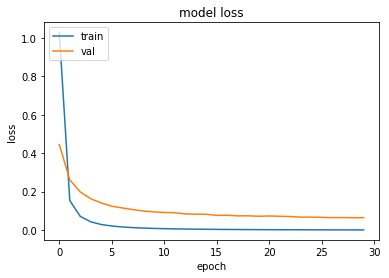

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

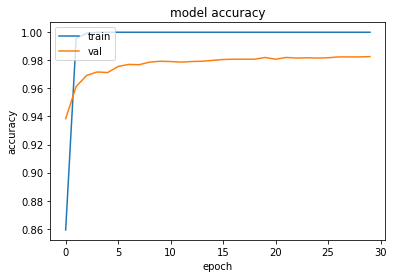

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
start=time.time()

scores = model.evaluate(
    test_images,
    test_labels, 
    batch_size = 32, 
    verbose = 1, 
    sample_weight=None, 
    steps=None)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

end=time.time()
runtime=end-start
print("Runtime: "+str(runtime)+"s")

4800/4832 [============================>.] - ETA: 0s
acc: 97.83%
Runtime: 5.720963716506958s
